# Exploring data

**Abstract:** Reading the data and preprocessing it before we turn to our first attempts at training. Also have a look at the `training` directory in this repository, where we eventually ended up with the training methods.

## Preamble

In [85]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import os
import sys
sys.path.append("../")
import utils
import h5py
import re

from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.training import SVDTrainingModel
from nmma.em.utils import calc_lc

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

## Loading the data

In [2]:
X, freqs, times = utils.read_X_file("./X_afgpy.h5")
times = times / (3600 * 24) # convert to days
Y = utils.read_Y_file("./Y_afgpy.h5")

In [3]:
lcdir = "../lcdir/"
filenames = os.listdir(lcdir)
print(f"There are {len(filenames)} files in the directory {lcdir}")

There are 16384 files in the directory ../lcdir/


Reading data from example file: n_ism_0.01_theta_obs_0.7853981633974483_Eiso_c_1e+53_theta_c_0.08726646259971647_p_fs_2.4_eps_e_fs_0.5_eps_b_fs_0.5.dat


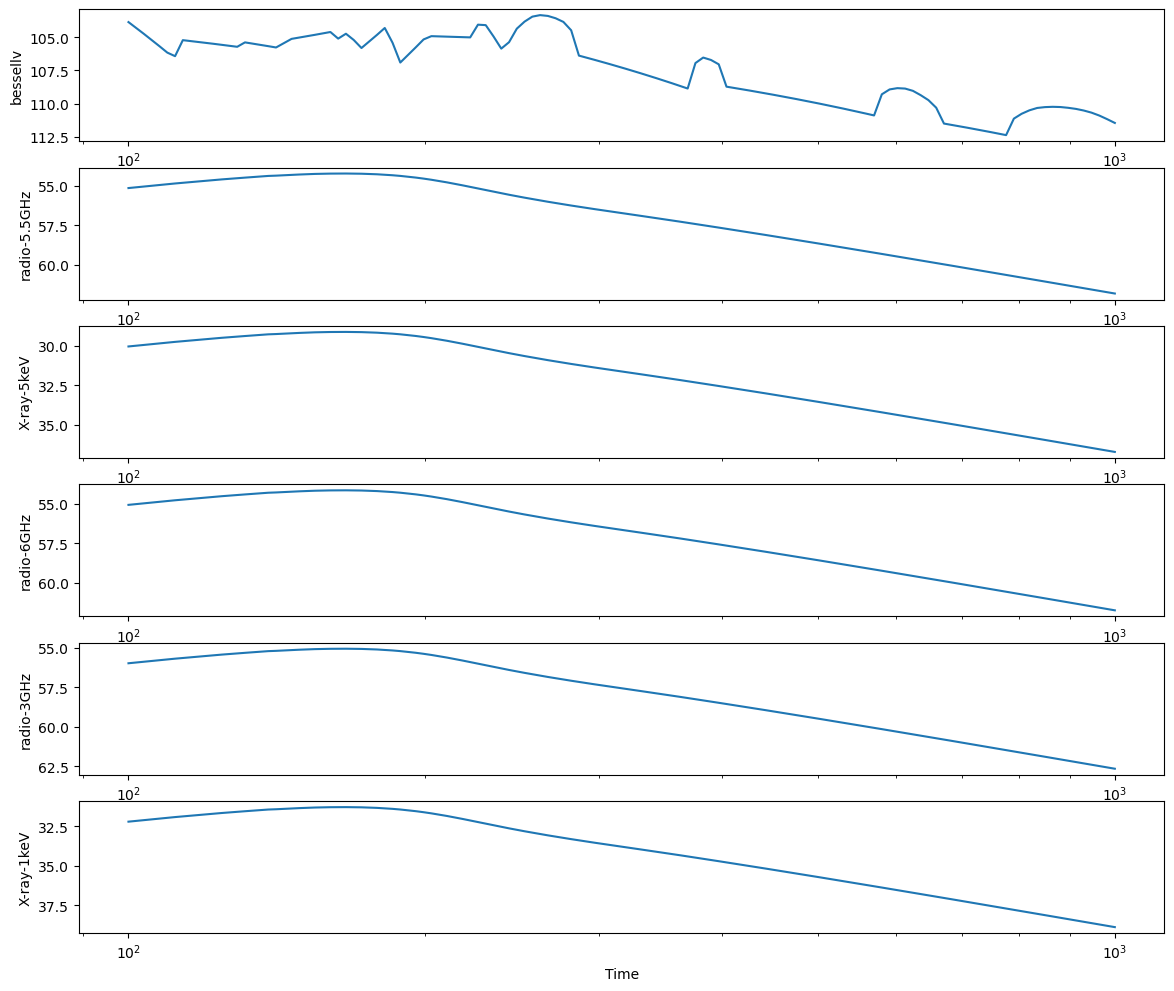

In [4]:
example_filename = filenames[10000]
print(f"Reading data from example file: {example_filename}")
data = np.loadtxt(lcdir + example_filename)

# plot an example
nrows = len(utils.filters)
plt.subplots(nrows = nrows, figsize=(14, 12))

for i, filt in enumerate(utils.filters):
    plt.subplot(nrows, 1, i+1)
    plt.plot(times, data[:, i])
    plt.ylabel(filt)
    plt.gca().invert_yaxis()
    plt.xscale("log")

plt.xlabel("Time")
plt.show()

## Fetching parameter values from filenames

In [5]:
lcs_dir = "../lcdir/"
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

data = read_photometry_files(full_filenames)
data = interpolate_nans(data)

There are 16384 lightcurves for this model.


In [6]:
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['X-ray-1keV', 'X-ray-5keV', 'bessellv', 'radio-3GHz', 'radio-5.5GHz', 'radio-6GHz']


In [7]:
def model_function(data):
    data_out = {}
    parameters = ['log10_n0', 'theta_obs', 'log10_E0', 'thetaCore', 'p', 'log10_eps_e', 'log10_eps_b']
    parameters_idx = [0, 1, 2, 3, 4, 5, 6]
    magkeys = data.keys()
    for jj, key in enumerate(magkeys):
        rr = [
            np.abs(float(x))
            for x in re.findall(
                r"[-+]?\d*\.\d+|\d+e[-+]?\d+|\d+", key
            )
        ]
        
        # Best to interpolate some parameters in log10 space
        rr[0] = np.log10(rr[0])
        rr[2] = np.log10(rr[2])
        rr[5] = np.log10(rr[5])
        rr[6] = np.log10(rr[6])
        data_out[key] = {
            param: rr[idx] for param, idx in zip(parameters, parameters_idx)
        }
        data_out[key] = {**data_out[key], **data[key]}
    
    return data_out, parameters

In [89]:
training_data, parameters = model_function(data)

In [90]:
keys = list(training_data.keys())
training_data_example = training_data[keys[0]]

dict_keys(['log10_n0', 'theta_obs', 'log10_E0', 'thetaCore', 'p', 'log10_eps_e', 'log10_eps_b', 'bessellv', 'radio-5.5GHz', 'X-ray-5keV', 'radio-6GHz', 'radio-3GHz', 'X-ray-1keV'])
{'log10_n0': 0.0, 'theta_obs': 0.0, 'log10_E0': 50.0, 'thetaCore': 0.08726646259971647, 'p': 2.2, 'log10_eps_e': -0.3010299956639812, 'log10_eps_b': -0.3010299956639812, 'bessellv': array([114.6497, 114.6238, 114.5979, 114.5721, 114.5461, 114.5201,
       114.4941, 114.4681, 114.442 , 114.4159, 114.3897, 114.3636,
       114.3374, 114.3111, 114.2848, 114.2574, 114.231 , 114.2046,
       114.1782, 114.1518, 114.1241, 114.0976, 114.071 , 114.0444,
       114.0166, 113.9899, 113.9632, 113.9364, 113.9085, 113.8816,
       113.8548, 113.8267, 113.7997, 113.7715, 113.7445, 113.7175,
       113.6892, 113.662 , 113.6336, 113.6064, 113.5779, 113.5507,
       113.5221, 113.4948, 113.4661, 113.4374, 113.41  , 113.3812,
       113.3537, 113.3248, 113.2959, 113.2678, 113.2393, 113.2103,
       113.1812, 113.1535, 113.124

**NOTE** The following is necessary, otherwise the code breaks apparently.

In [91]:
for key in training_data:
    training_data[key]["t"] = times

## Getting the SVD model

**NOTE** Leaving out the Bessel filter for now as it seems to be acting a bit weird

In [92]:
training_model = SVDTrainingModel("afterglowpy_svd",
                                  training_data,
                                  parameters,times,
                                  ["radio-5.5GHz", "X-ray-5keV", "radio-6GHz",  "radio-3GHz", "X-ray-1keV"],
                                  n_coeff= 10,
                                  interpolation_type="tensorflow",
                                  start_training=False # don't train, just prep the data
    )

The grid will be interpolated to sample_time with interp1d


In [93]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter radio-5.5GHz...
Normalizing mag filter X-ray-5keV...
Normalizing mag filter radio-6GHz...
Normalizing mag filter radio-3GHz...
Normalizing mag filter X-ray-1keV...


## Training NN

For testing, we are going to train on a specific filter

In [96]:
example_filter = "radio-5.5GHz"

In [97]:
X = training_model.svd_model[example_filter]['param_array_postprocess'] # complete dataset of input data of network
n_samples, input_ndim = X.shape
print(f"Features (input) have shape {X.shape}")

y = training_model.svd_model[example_filter]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels (output) have shape {y.shape}")

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=0)

Features (input) have shape (16384, 7)
Labels (output) have shape (16384, 10)


In [98]:
model = Sequential()
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(
    Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(Dense(training_model.n_coeff))

# Show the architecture:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                512       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 17,738
Trainable params: 17,738
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.compile(optimizer="adam", loss="mse")
n_epochs = 100

# fit the model
start = time.time()
training_history = model.fit(
    train_X,
    train_y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(val_X, val_y),
    verbose=True,
)
end = time.time()
print(f"Time to train: {end - start} seconds")

Epoch 1/100
384/384 [==============================] - 4s 6ms/step - loss: 0.2216 - val_loss: 0.0219
Epoch 2/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0131 - val_loss: 0.0073
Epoch 3/100
384/384 [==============================] - 2s 4ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 4/100
384/384 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/100
384/384 [==============================] - 2s 4ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/100
384/384 [==============================] - 2s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
384/384 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/100
384/384 [==============================] - 2s 5ms/step - loss: 0.0016 - val_lo

In [ ]:
svd_path = "/home/urash/twouters/new_nmma_models/Bu2023Ye_tf" # location on the Potsdam cluster
training_model.svd_path = svd_path

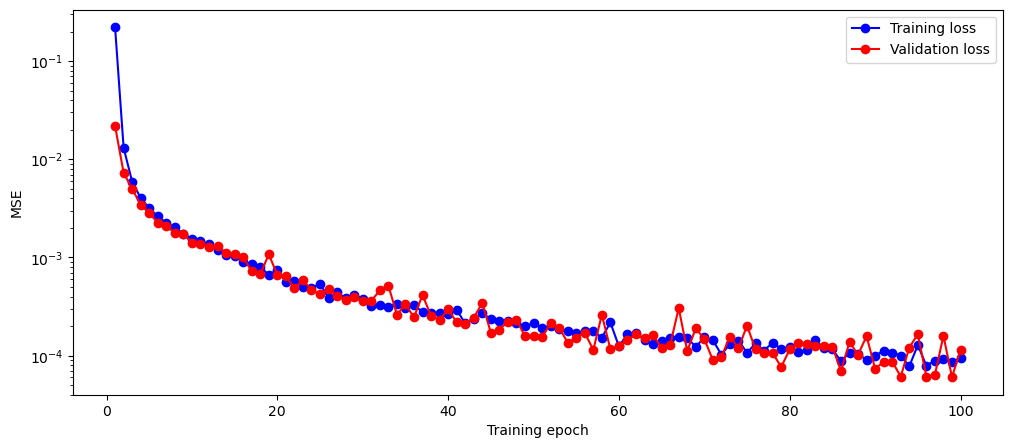

In [100]:
train_loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.plot([i+1 for i in range(len(train_loss))], train_loss, '-o', color="blue", label="Training loss")
plt.plot([i+1 for i in range(len(val_loss))], val_loss, '-o', color="red", label="Validation loss")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

In [101]:
training_model.svd_model[example_filter]["model"] = model

## Checking output

In [104]:
def calc_lc_grb(
    tt: np.array,
    param_list: np.array,
    svd_mag_model: SVDTrainingModel=None,
    svd_lbol_model: SVDTrainingModel=None,
    mag_ncoeff: int=None,
    lbol_ncoeff: int=None,
    interpolation_type: str="sklearn_gp",
    filters: list=None,
) -> "tuple[np.array, np.array, np.array]":
    """
    Computes the lightcurve from a surrogate model, given the model parameters.
    Args:
        tt (Array): Time grid on which to evaluate lightcurve
        param_list (Array): Input parameters for the surrogate model
        svd_mag_model (SVDTrainingModel): Trained surrogate model for mag
        svd_lbol_model (SVDTrainingModel): Trained surrogate model for lbol
        mag_ncoeff (int): Number of coefficients after SVD projection for mag
        lbol_ncoeff (int): Number of coefficients after SVD projection for lbol
        interpolation_type (str): String denoting which interpolation type is used for the surrogate model
        filters (Array): List/array of filters at which we want to evaluate the model
    """

    mAB = {}

    if filters is None:
        filters = list(svd_mag_model.keys())

    for jj, filt in enumerate(filters):
        if filt in mAB:
            continue

        if mag_ncoeff:
            n_coeff = min(mag_ncoeff, svd_mag_model[filt]["n_coeff"])
        else:
            n_coeff = svd_mag_model[filt]["n_coeff"]
        VA = svd_mag_model[filt]["VA"]
        param_mins = svd_mag_model[filt]["param_mins"]
        param_maxs = svd_mag_model[filt]["param_maxs"]
        mins = svd_mag_model[filt]["mins"]
        maxs = svd_mag_model[filt]["maxs"]
        tt_interp = svd_mag_model[filt]["tt"]

        param_list_postprocess = np.array(param_list)
        for i in range(len(param_mins)):
            param_list_postprocess[i] = (param_list_postprocess[i] - param_mins[i]) / (
                param_maxs[i] - param_mins[i]
            )

        if interpolation_type == "tensorflow":
            model = svd_mag_model[filt]["model"]
            cAproj = model(np.atleast_2d(param_list_postprocess)).numpy().T.flatten()
            cAstd = np.ones((n_coeff,))
        elif interpolation_type == "api_gp":
            seed = 32
            random_state = np.random.RandomState(seed)

            gps = svd_mag_model[filt]["gps"]
            cAproj = np.zeros((n_coeff,))
            cAstd = np.zeros((n_coeff,))
            for i in range(n_coeff):
                gp = gps[i]
                y_pred = gp.mean(np.atleast_2d(param_list_postprocess))
                y_samples_test = gp.rvs(
                    100,
                    np.atleast_2d(param_list_postprocess),
                    random_state=random_state,
                )
                y_90_lo_test, y_90_hi_test = np.percentile(
                    y_samples_test, [5, 95], axis=1
                )
                cAproj[i] = y_pred
                cAstd[i] = y_90_hi_test - y_90_lo_test
        else:
            gps = svd_mag_model[filt]["gps"]
            if gps is None:
                raise ValueError(
                    f"Gaussian process model for filter {filt} unavailable."
                )

            cAproj = np.zeros((n_coeff,))
            cAstd = np.zeros((n_coeff,))
            for i in range(n_coeff):
                gp = gps[i]
                y_pred, sigma2_pred = gp.predict(
                    np.atleast_2d(param_list_postprocess), return_std=True
                )
                cAproj[i] = y_pred
                cAstd[i] = sigma2_pred

        mag_back = np.dot(VA[:, :n_coeff], cAproj)
        mag_back = mag_back * (maxs - mins) + mins

        # TODO: check for a reasonable upper time limit here
        ii = np.where((~np.isnan(mag_back)) * (tt_interp < 1100.0))[0]
        if len(ii) < 2:
            maginterp = np.nan * np.ones(tt.shape)
        else:
            f = interp.interp1d(tt_interp[ii], mag_back[ii], fill_value="extrapolate")
            maginterp = f(tt)
        mAB[filt] = maginterp

    if svd_lbol_model is not None:
        if lbol_ncoeff:
            n_coeff = min(lbol_ncoeff, svd_lbol_model["n_coeff"])
        else:
            n_coeff = svd_lbol_model["n_coeff"]
        VA = svd_lbol_model["VA"]
        param_mins = svd_lbol_model["param_mins"]
        param_maxs = svd_lbol_model["param_maxs"]
        mins = svd_lbol_model["mins"]
        maxs = svd_lbol_model["maxs"]
        gps = svd_lbol_model["gps"]
        tt_interp = svd_lbol_model["tt"]

        param_list_postprocess = np.array(param_list)
        for i in range(len(param_mins)):
            param_list_postprocess[i] = (param_list_postprocess[i] - param_mins[i]) / (
                param_maxs[i] - param_mins[i]
            )

        if interpolation_type == "tensorflow":
            model = svd_lbol_model["model"]
            cAproj = model.predict(np.atleast_2d(param_list_postprocess)).T.flatten()
            cAstd = np.ones((n_coeff,))
        else:
            cAproj = np.zeros((n_coeff,))
            for i in range(n_coeff):
                gp = gps[i]
                y_pred, sigma2_pred = gp.predict(
                    np.atleast_2d(param_list_postprocess), return_std=True
                )
                cAproj[i] = y_pred

        lbol_back = np.dot(VA[:, :n_coeff], cAproj)
        lbol_back = lbol_back * (maxs - mins) + mins

        ii = np.where(~np.isnan(lbol_back))[0]
        if len(ii) < 2:
            lbolinterp = np.nan * np.ones(tt.shape)
        else:
            f = interp.interp1d(tt_interp[ii], lbol_back[ii], fill_value="extrapolate")
            lbolinterp = 10 ** f(tt)
        lbol = lbolinterp
    else:
        lbol = np.inf * np.ones(len(tt))

    return np.squeeze(tt), np.squeeze(lbol), mAB

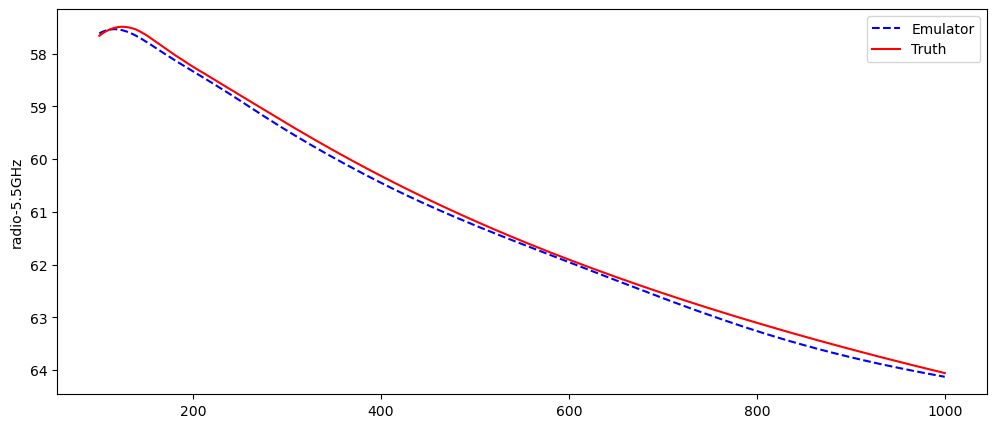

In [156]:
# TODO: improve this mess here
idx = 4002
# example_filter_index = filts.index(example_filter)
example_filter_index = 0

keys = np.array(list(training_data.keys()))
example_name = keys[idx]
key = list(training_data.keys())[idx]
example = training_data[example_name]
example_data = example["data"]
raw_lightcurve = example_data[:, example_filter_index]
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = np.array(example_parameters)

# Get time grid
t = times
_, _, mAB = calc_lc_grb(t,
                        example_parameters, 
                        svd_mag_model = training_model.svd_model, 
                        interpolation_type="tensorflow", 
                        filters = [example_filter], 
                        mag_ncoeff = 10
)

### Plot

fig, ax = plt.subplots(figsize=(12, 5))
# Plot the surrogate output
plt.plot(t, mAB[example_filter], color="blue", linestyle = "--", label = "Emulator")

# Also plot the raw data (also processed, interpolated etc)
plt.plot(t, raw_lightcurve, color = "red", label = "Truth")
plt.ylabel(example_filter, rotation=90)
ax.invert_yaxis()
plt.legend()
plt.show()